# Registration Methods 

This *Jupyter Notebook* is dedicated to the study of **Rigid Registration Methods**. 

The following study will be developed by the implementation of *Python* code for the application and visualization of the concepts learned with the use of *NumPy* and *Plotly* libraries. 

---

## Visual Setup

The plotting of the interactive graphic visuals will be done by a `Viewer` object based on the *Plotly*'s `Figure` object.

---

In [10]:
# Importing modules...
from modules.frame  import *
from modules.viewer import *
from modules.rigid  import *

## Validation Metrics

In each algorithm tryout, a **ground truth** rigid transformation will be randomly generated - composed of a rotation matrix and and a translation vector $R$ and $t$ (or in homogeneous representation, $H$).  

This rigid transformation will be applied to an original point-set $A$, generating the new point-set $B$, such that:

$$B = R\cdot A + t$$

or 

$$\tilde{B} = H \cdot \tilde{A}$$

Then, the proposed algorithm will calculate the estimated rotation matrix and translation vector $R_e$ and $t_e$ (or in homogeneous transformation, $H_e$). 

To verify how close these parameters are from the ground truth, both transformations, expressed in the homogeneous form, should satisfy as closely as possible the following expression:

$$||H-H_e|| \approx 0$$



---

In [11]:
# This function returns the norm of the difference between two matrices 
def dissimilarity(H, H_e):
    return np.linalg.norm(H-H_e)

## The Kabsch Algorithm

The Kabsch algorithm, also known as the Kabsch-Umeyama algorithm, named after Wolfgang Kabsch and Shinji Umeyama, is a method for calculating the optimal rotation matrix that minimizes the RMSD (root mean squared deviation) between two paired sets of points. It is useful for point-set registration in computer graphics, and in cheminformatics and bioinformatics to compare molecular and protein structures.

The following code is adapted and displayed from [here](http://nghiaho.com/?page_id=671).

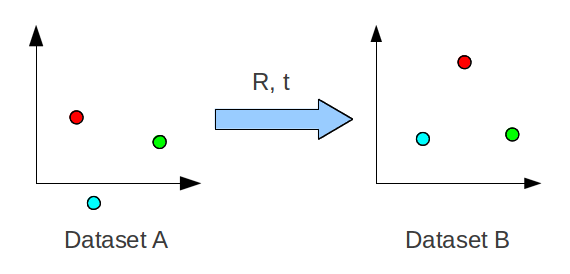

The main goal of the algorithm is finding the best rotation and translation ('best' in terms of least square errors) that will allign Dataset A to Dataset B.

The algorithm follows:
1. Recenter both datasets in the origin by their centroids;
2. Find the optimal rotation $R$ between the recentered datasets;
3. Recalculate their relative translation.

### Recentering the Datasets

Find both of the dataset centroids. These vectors are found via the average position of the points in the datasets.

$$\bar{A} = \frac{1}{N} \sum\limits_{i=1}^N A^i$$

$$\bar{B} = \frac{1}{N} \sum\limits_{i=1}^N B^i$$

To recentralize the datasets in the origin:

$$A_0 = A - \bar{A}$$

$$B_0 = B - \bar{B}$$

### Finding the Optimal Rotation

Now we aim to solve for the rotation matrix between the datasets around the origin disregarding the translation component.

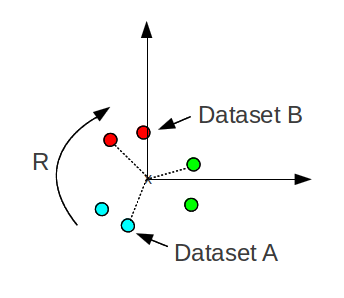

For this, the cross covariance matrix $H$ of the two datasets is decomposed using Singular Value Decomposition.

The cross-covariance matrix is defined by:

$$H = (A - \bar{A})(B - \bar{B})^T$$

The Singular Value Decomposition of a cross-covariance matrix between two datasets is oftenly used to calculate their rotation between each other.

$$[U,\Sigma,V^T] = SVD(H)$$ 

Geometrically, since the vector $\Sigma$ represents a "stretching" between datasets, and our analyzed transformation is supposedly rigid, $\Sigma$ is an identity matrix.

So finally, the rotation matrix $R$ will be the transposed of the given SVD:

$$R= SVD(H)^T = (U\cdot V^T)^T = V\cdot U^T$$

If the determinant of the SVD is negative, we should multiply the last column of V^T by -1. Sometimes the SVD can calculate a reflected case ($\det{R} = -1$) and this does not make any sense in the context of rigid transformations, because rigid transformation matrices will always have a determinant of +1.

### Finding the Translation

To solve for the translation vector $t$, we may use the prior result. Since:
$$R\cdot A + t = B$$

Then:
$$R\cdot\bar{A} + t = \bar{B}$$ 

And finally:
$$t = \bar{B} - R\cdot\bar{A}$$

---

In [14]:
# Find rotation and translation to align point-set A to point-set B
def kabsch(A, B):
    assert A.shape == B.shape

    # Find centroids and ensure they are 3x1
    A_c = np.mean(A, axis=1).reshape(-1, 1)
    B_c = np.mean(B, axis=1).reshape(-1, 1)

    # Centralize point-sets in origin
    A_0 = A - A_c
    B_0 = B - B_c

    H = A_0 @ np.transpose(B_0)

    # Find rotation using Singular Value Decomposition
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # Special reflection case
    if np.linalg.det(R) < 0: # The rotation matrix determinant should be +1
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    # Finding translation vector
    t = -R @ A_c + B_c

    return R, t

# Create graph viewer
viewer = Viewer('Kabsch Algorithm Implementation', graphical=True, size=2)

# Plot main frame
viewer.add_frame(Frame(), 'W')

# Original point-set
nPoints = 4
psA = square(position=np.array([1/2,1/2,0]).reshape(-1,1), size=1/10)

# Plot A
for i, A in enumerate(psA.T):
    viewer.add_point(A.reshape(-1,1), name=f'A{i}', color='red')

# Random rotation and translation
R, t = randR(), randt(1)

# Point-set B is a rotated and translated point-set A
psB = R @ psA + t

# Introduce noise in point-set B by changing the maximum noise distance delta
delta = 0
N = np.hstack(np.array([randt(delta) for _ in range(nPoints)])) # Noise matrix
psB += N

# Plot B
for i, B in enumerate(psB.T):
    viewer.add_point(B.reshape(-1,1), name=f'B{i}', color='blue')

# Calculated R and t by the Kabsch algorithm
R_e, t_e = kabsch(psA, psB)

# Estimated B
psB_e = R_e @ psA + t_e

# Plot estimated point-set B
for i, B_e in enumerate(psB_e.T):
    viewer.add_point(B_e.reshape(-1,1), name=f'Be{i}', color='green')
# If the algorithm is satisfactorily implemented, the green dataset (Estimated B) 
# must be as similar as possible as the blue dataset (Ground Truth B)

print('Norm of the difference: ', dissimilarity(join_homo(R, t), join_homo(R_e, t_e)))

viewer.figure.show(renderer='notebook_connected') # Choose renderer: 'notebook' for offline mode and 'browser' for browser plots

Norm of the difference:  9.243065094059318e-16
